**Import** **the** **necessary** **packages**


In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

ANOTHER_RANDOM_SEED = 99  # Choose another random seed
np.random.seed(ANOTHER_RANDOM_SEED)
torch.manual_seed(ANOTHER_RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

.

.

**Import** **the** **dataset**

In [2]:
cols = ['sentiment', 'id', 'date', 'query', 'user','tweet']
df = pd.read_csv("Twitter.csv", encoding='latin',names=cols)

In [3]:
new_df = df.drop(['id', 'date', 'query', 'user'],axis=True)
new_df.tail(5)

,sentiment,tweet
1048566,4,My GrandMa is making Dinenr with my Mum
1048567,4,Mid-morning snack time... A bowl of cheese noo...
1048568,4,@ShaDeLa same here say it like from the Termi...
1048569,4,@DestinyHope92 im great thaanks wbuu?
1048570,4,cant wait til her date this weekend


In [4]:
# @title Data Exploration


.

**Data** **Exploration**


In [5]:
new_df['sentiment'].value_counts()

0    799995
4    248576
Name: sentiment, dtype: int64

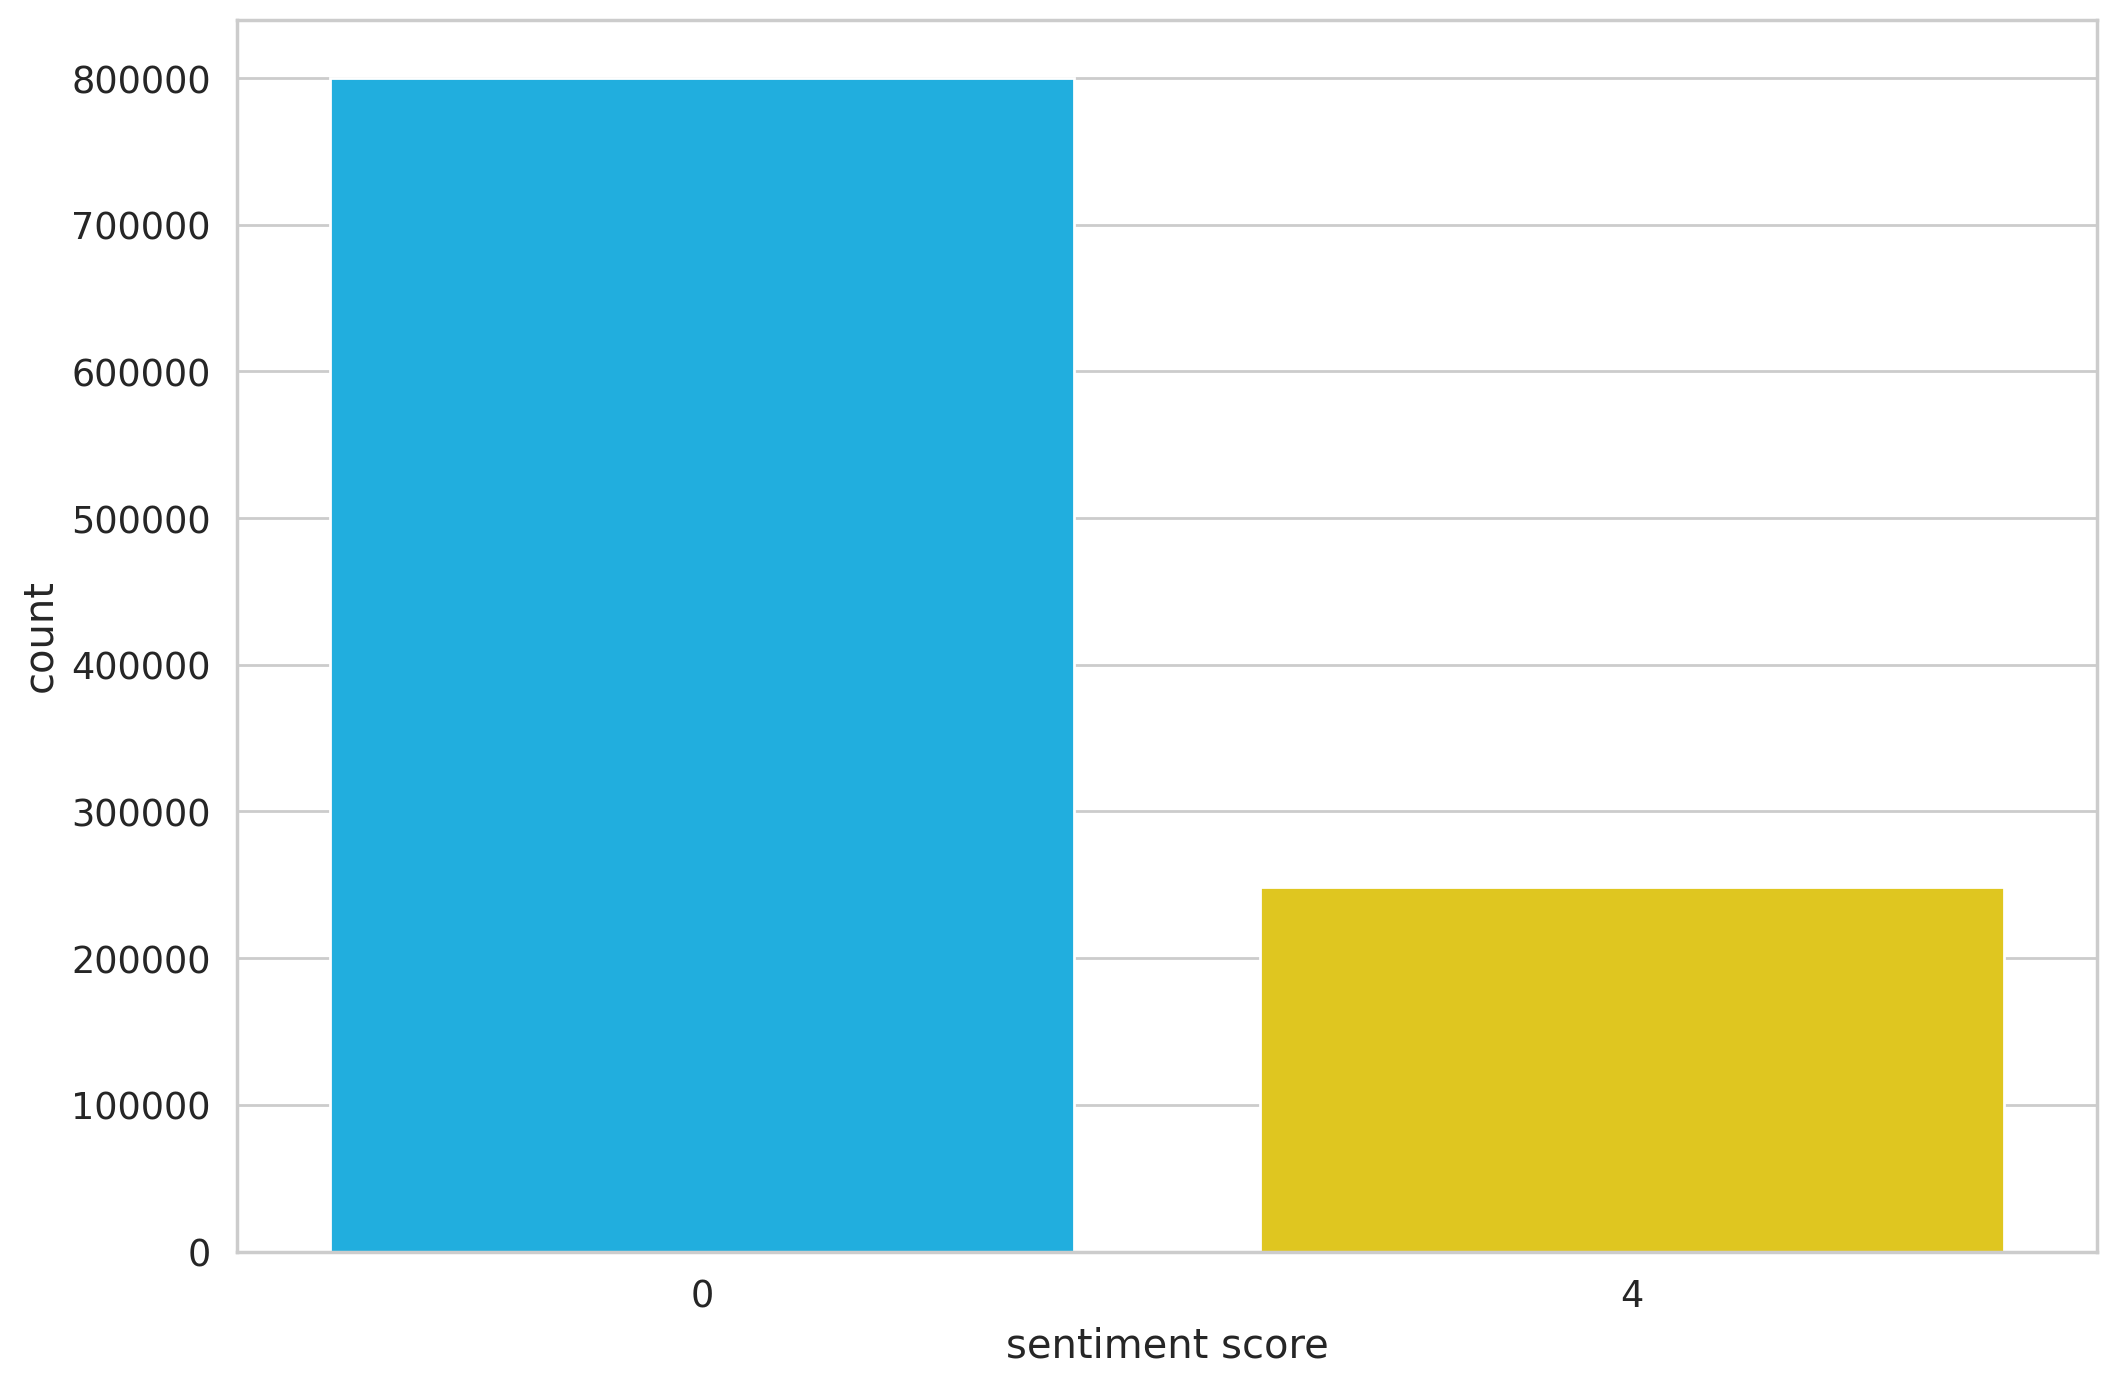

In [6]:
sns.countplot(x='sentiment', data=new_df)
plt.xlabel('sentiment score');

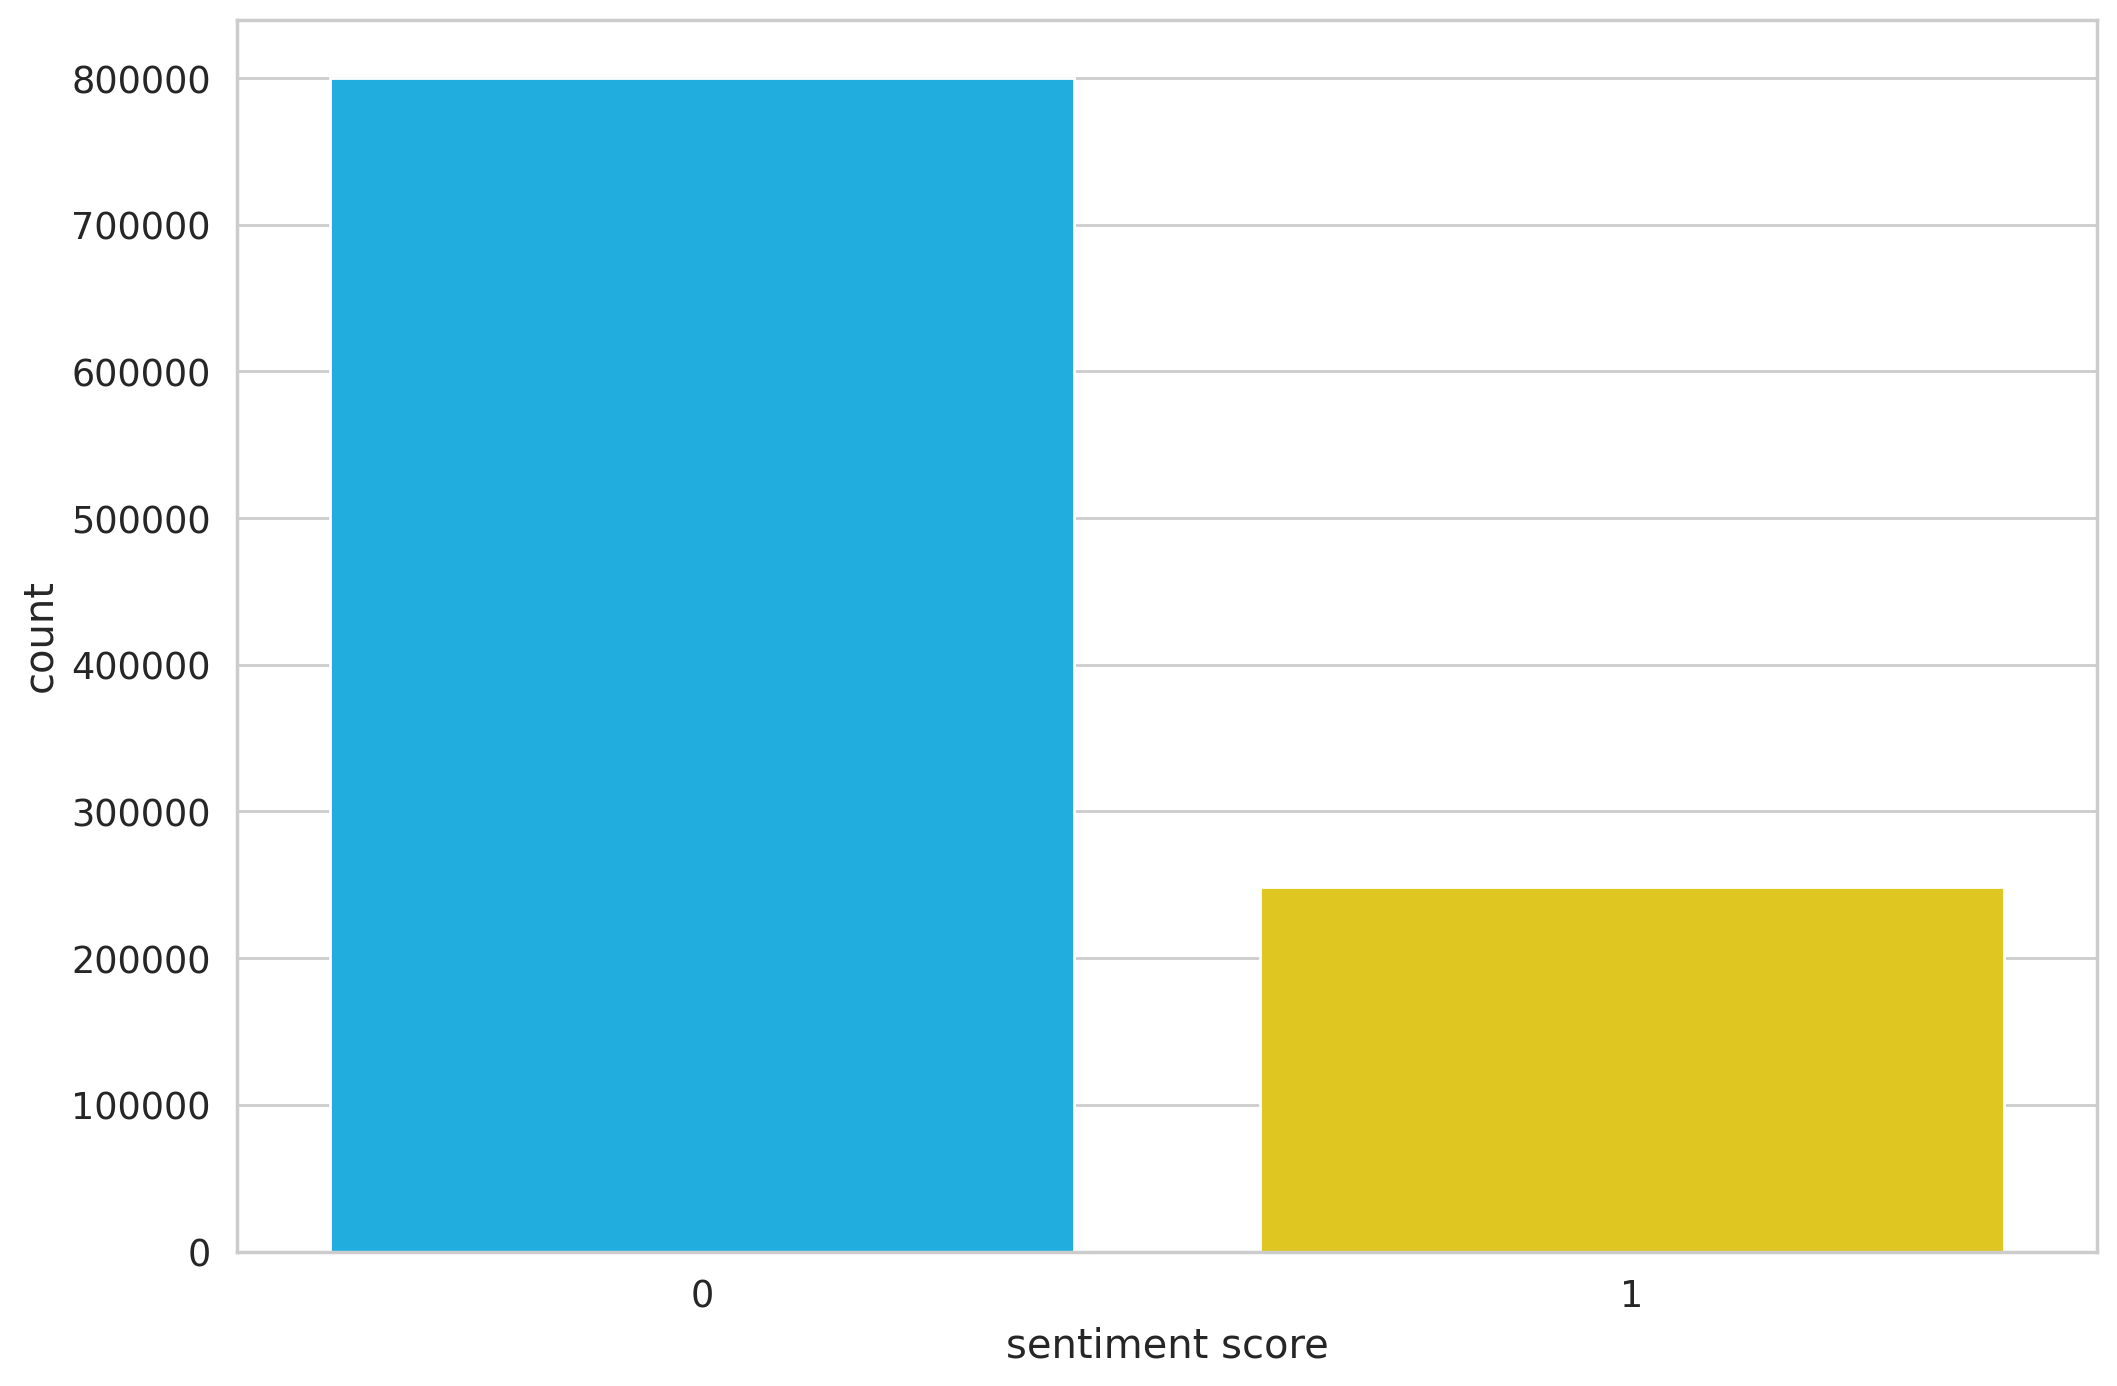

In [7]:
class_names=['negative', 'positive']
ax=sns.countplot(x='sentiment', data=new_df)
plt.xlabel('sentiment score');
ax.set_xticklabels(range(len(class_names)));

In [8]:
# @title Data preprocessing using the NLTK library


.

**Data** **preprocessing** **using** **the** **NLTK** **library**


In [9]:
def preprocess_data(input_text):

    # Converting to lowercase
    input_text = input_text.lower()

    # URL removal
    input_text = re.sub(r"http\S+|www\S+|https\S+", "", input_text, flags=re.MULTILINE)


    # Numerical character removal
    input_text = re.sub('[0-9]+', '', input_text)

    # Removing user@ references and #
    input_text = re.sub(r'\@\w+|\#w+', "", input_text)

    # Output
    return " ".join(lemmatized_words)

In [10]:
# Dataset Reduction
limit = 248576
negatives = new_df[0:limit]
positives = new_df[799998:799998 + limit]
working_data = pd.concat([negatives, positives])


In [11]:
working_data['sentiment'][working_data['sentiment']== 4] = 1
working_data['sentiment'][working_data['sentiment']== 0] = 0

<ipython-input-11-5d0f48dd8172>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_data['sentiment'][working_data['sentiment']== 4] = 1
<ipython-input-11-5d0f48dd8172>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_data['sentiment'][working_data['sentiment']== 0] = 0


In [12]:
working_data['sentiment'].value_counts()

0    248576
1    248573
Name: sentiment, dtype: int64

In [13]:
working_data.head(5)

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [14]:
new_df.tweet[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [15]:
working_data.tweet[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [16]:
tweet = working_data.tweet.values
sentiment = working_data.sentiment.values

.

 Tokenization Using BERTTokenizer pre-trained model

In [17]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

.

**Choosing** **sequence** **Length**

In [18]:

token_lens = []

for txt in tweet:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-19-0fcf9e80683b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


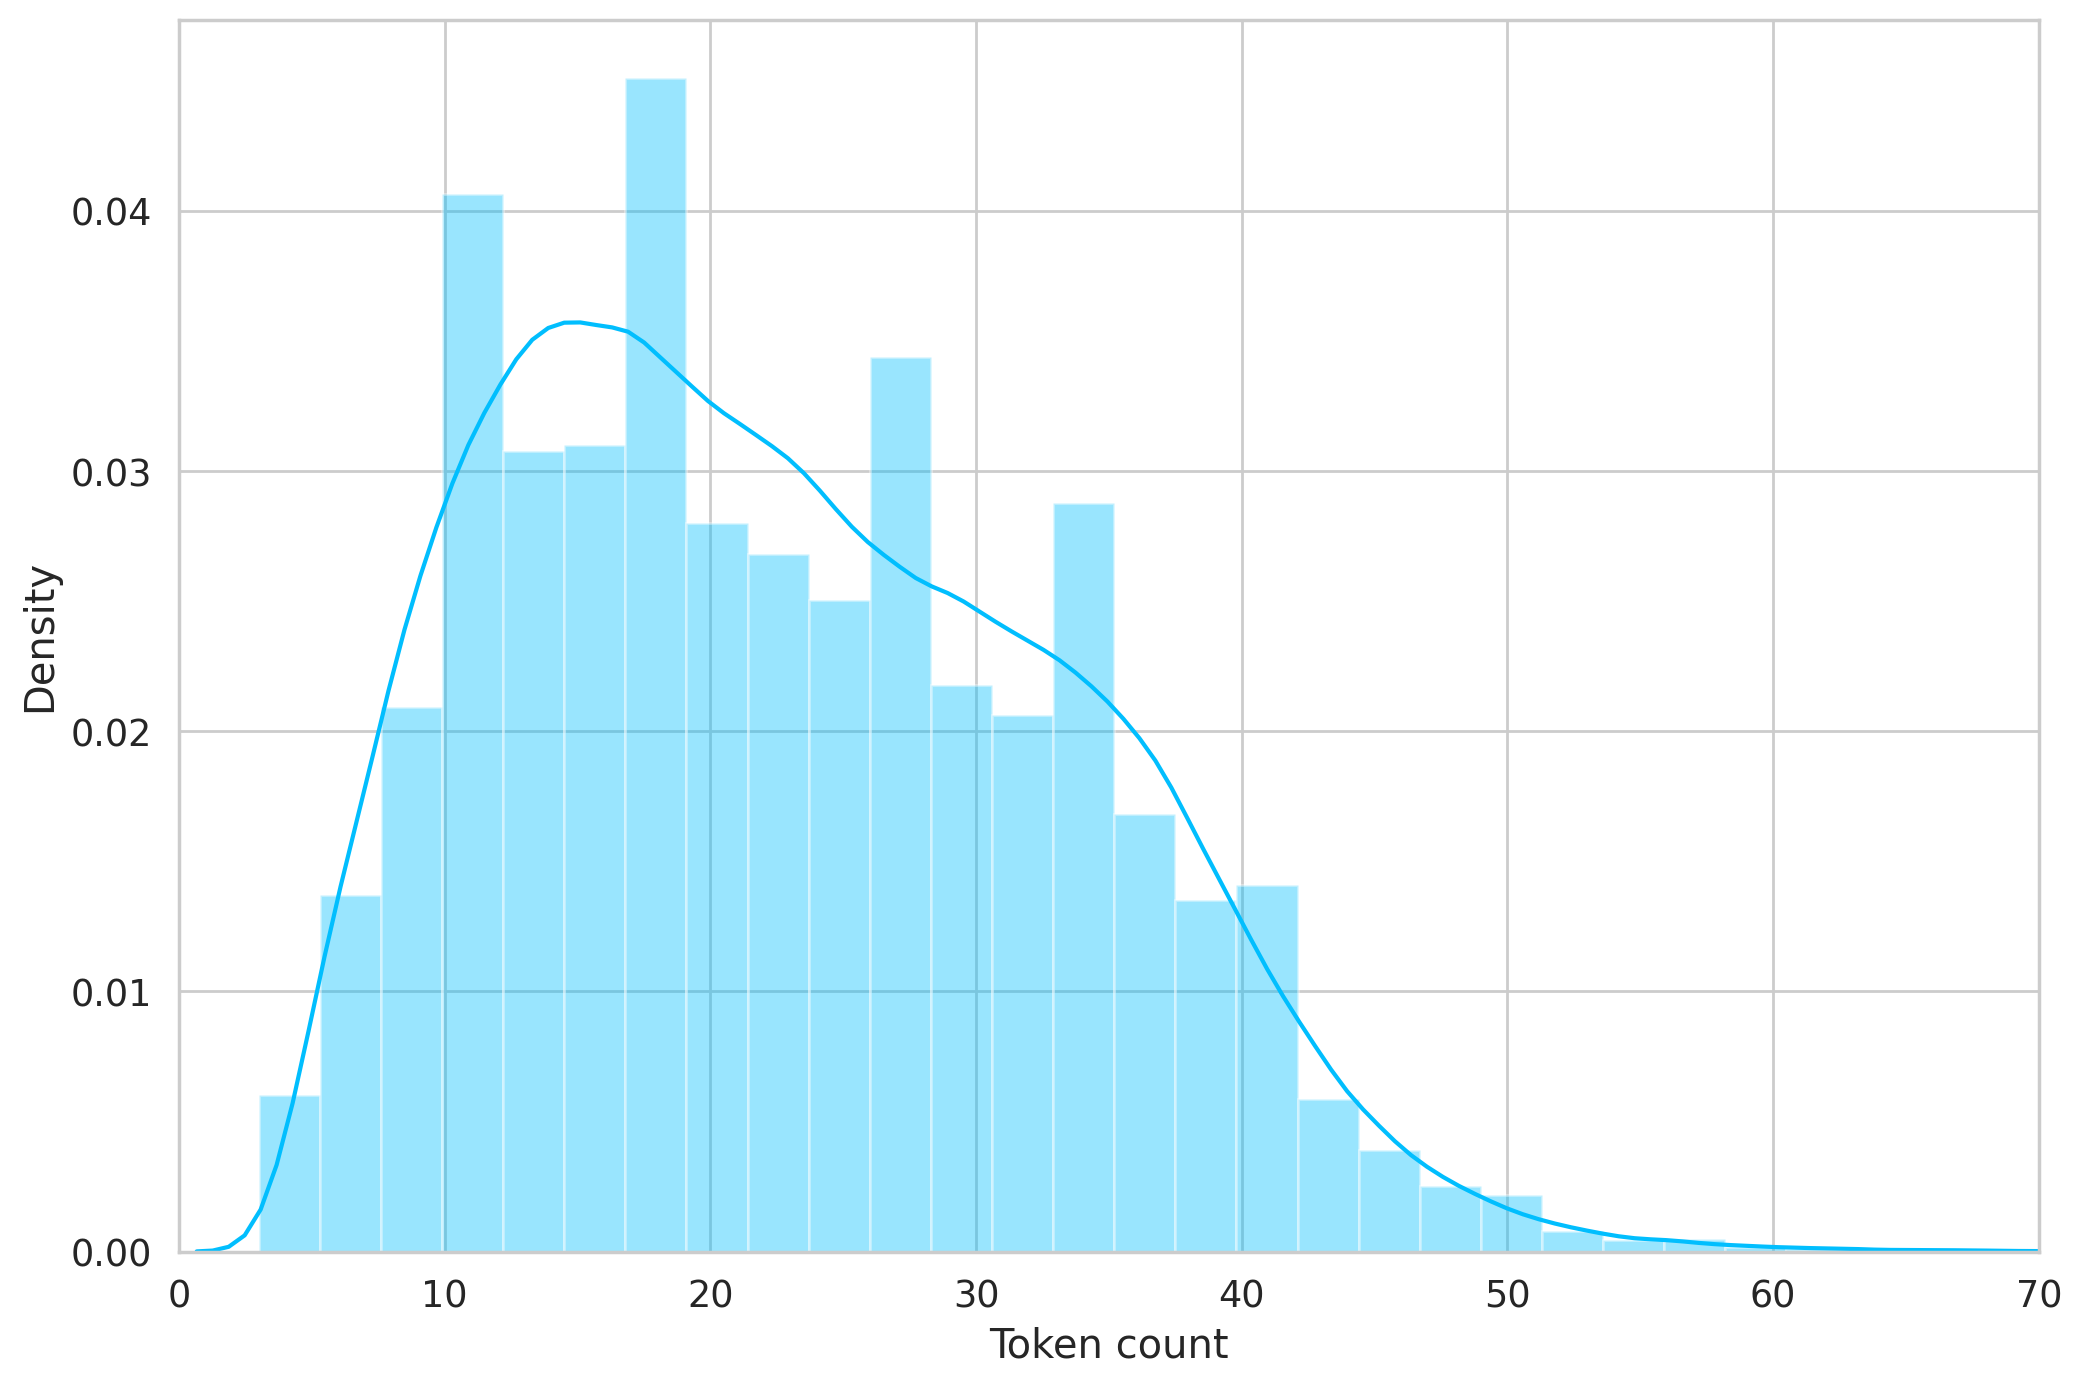

In [19]:

sns.distplot(token_lens)
plt.xlim([0, 70]);
plt.xlabel('Token count');

.

**Creating** **Pytorch** **Dataset**

In [20]:
class TweetDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'original_tweet': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


.

**Splitting** **Data** **into** **Train** **Test** **and** **Validation** **sets**

In [21]:
df_train, df_test = train_test_split(working_data, test_size=0.5, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [22]:
df_train.shape, df_val.shape, df_test.shape


((248574, 2), (124287, 2), (124288, 2))

.

 **Creating** **Data** **Loaders**


In [23]:
def create_data_loader(working_data, tokenizer, max_len, batch_size):
  ds = TweetDataset(
      tweets=working_data.tweet.to_numpy(),
      targets=working_data.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
      )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=2
      )
BATCH_SIZE = 16
MAX_LEN = 50


train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [24]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['original_tweet', 'input_ids', 'attention_mask', 'targets'])

In [25]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)


torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


In [26]:
MAX_LEN = 70


.

**Sentiment** **Classification** **with** **BERT** **and** **Hugging** **Face**

In [27]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig

bert = BertModel.from_pretrained('bert-base-uncased')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [28]:
class SentimentClassifier(nn.Module):
    def __init__(self, bert, num_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits


In [29]:
model = SentimentClassifier(bert, num_classes=2)
model = model.to(device)

In [30]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 50])
torch.Size([16, 50])


In [31]:
F.softmax(model(input_ids, attention_mask), dim=1)


tensor([[0.6365, 0.3635],
        [0.5292, 0.4708],
        [0.5912, 0.4088],
        [0.5763, 0.4237],
        [0.5600, 0.4400],
        [0.5380, 0.4620],
        [0.6169, 0.3831],
        [0.6050, 0.3950],
        [0.7026, 0.2974],
        [0.5394, 0.4606],
        [0.6527, 0.3473],
        [0.4853, 0.5147],
        [0.5667, 0.4333],
        [0.5446, 0.4554],
        [0.5461, 0.4539],
        [0.5570, 0.4430]], grad_fn=<SoftmaxBackward0>)

.

**Training**

In [32]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)



.

**Evaluate** **Model**

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for batch_idx, data in enumerate(val_data_loader):
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      targets = data['targets'].to(device)


      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      loss = loss_fn(outputs, targets)

      _, preds = torch.max(outputs, dim=1)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')


  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.3640927831661752 accuracy 0.8385752331297722
Val   loss 0.3291269567844014 accuracy 0.8584164071865923

Epoch 2/4
----------
Train loss 0.25587566755322383 accuracy 0.8942608639680739
Val   loss 0.35683990461559034 accuracy 0.8555842525766975

Epoch 3/4
----------
Train loss 0.1607428311544037 accuracy 0.938823046658138
Val   loss 0.4216116830284216 accuracy 0.8509417718667278

Epoch 4/4
----------
Train loss 0.10249445045988943 accuracy 0.9625463644628963
Val   loss 0.5080856195691819 accuracy 0.8529371535236991

CPU times: user 11d 12h 47min 1s, sys: 4h 25min 47s, total: 11d 17h 12min 49s
Wall time: 14h 3min 48s


.

**Plotting** **Accuracy** **for** **Both** **Training** **And** **Validation**

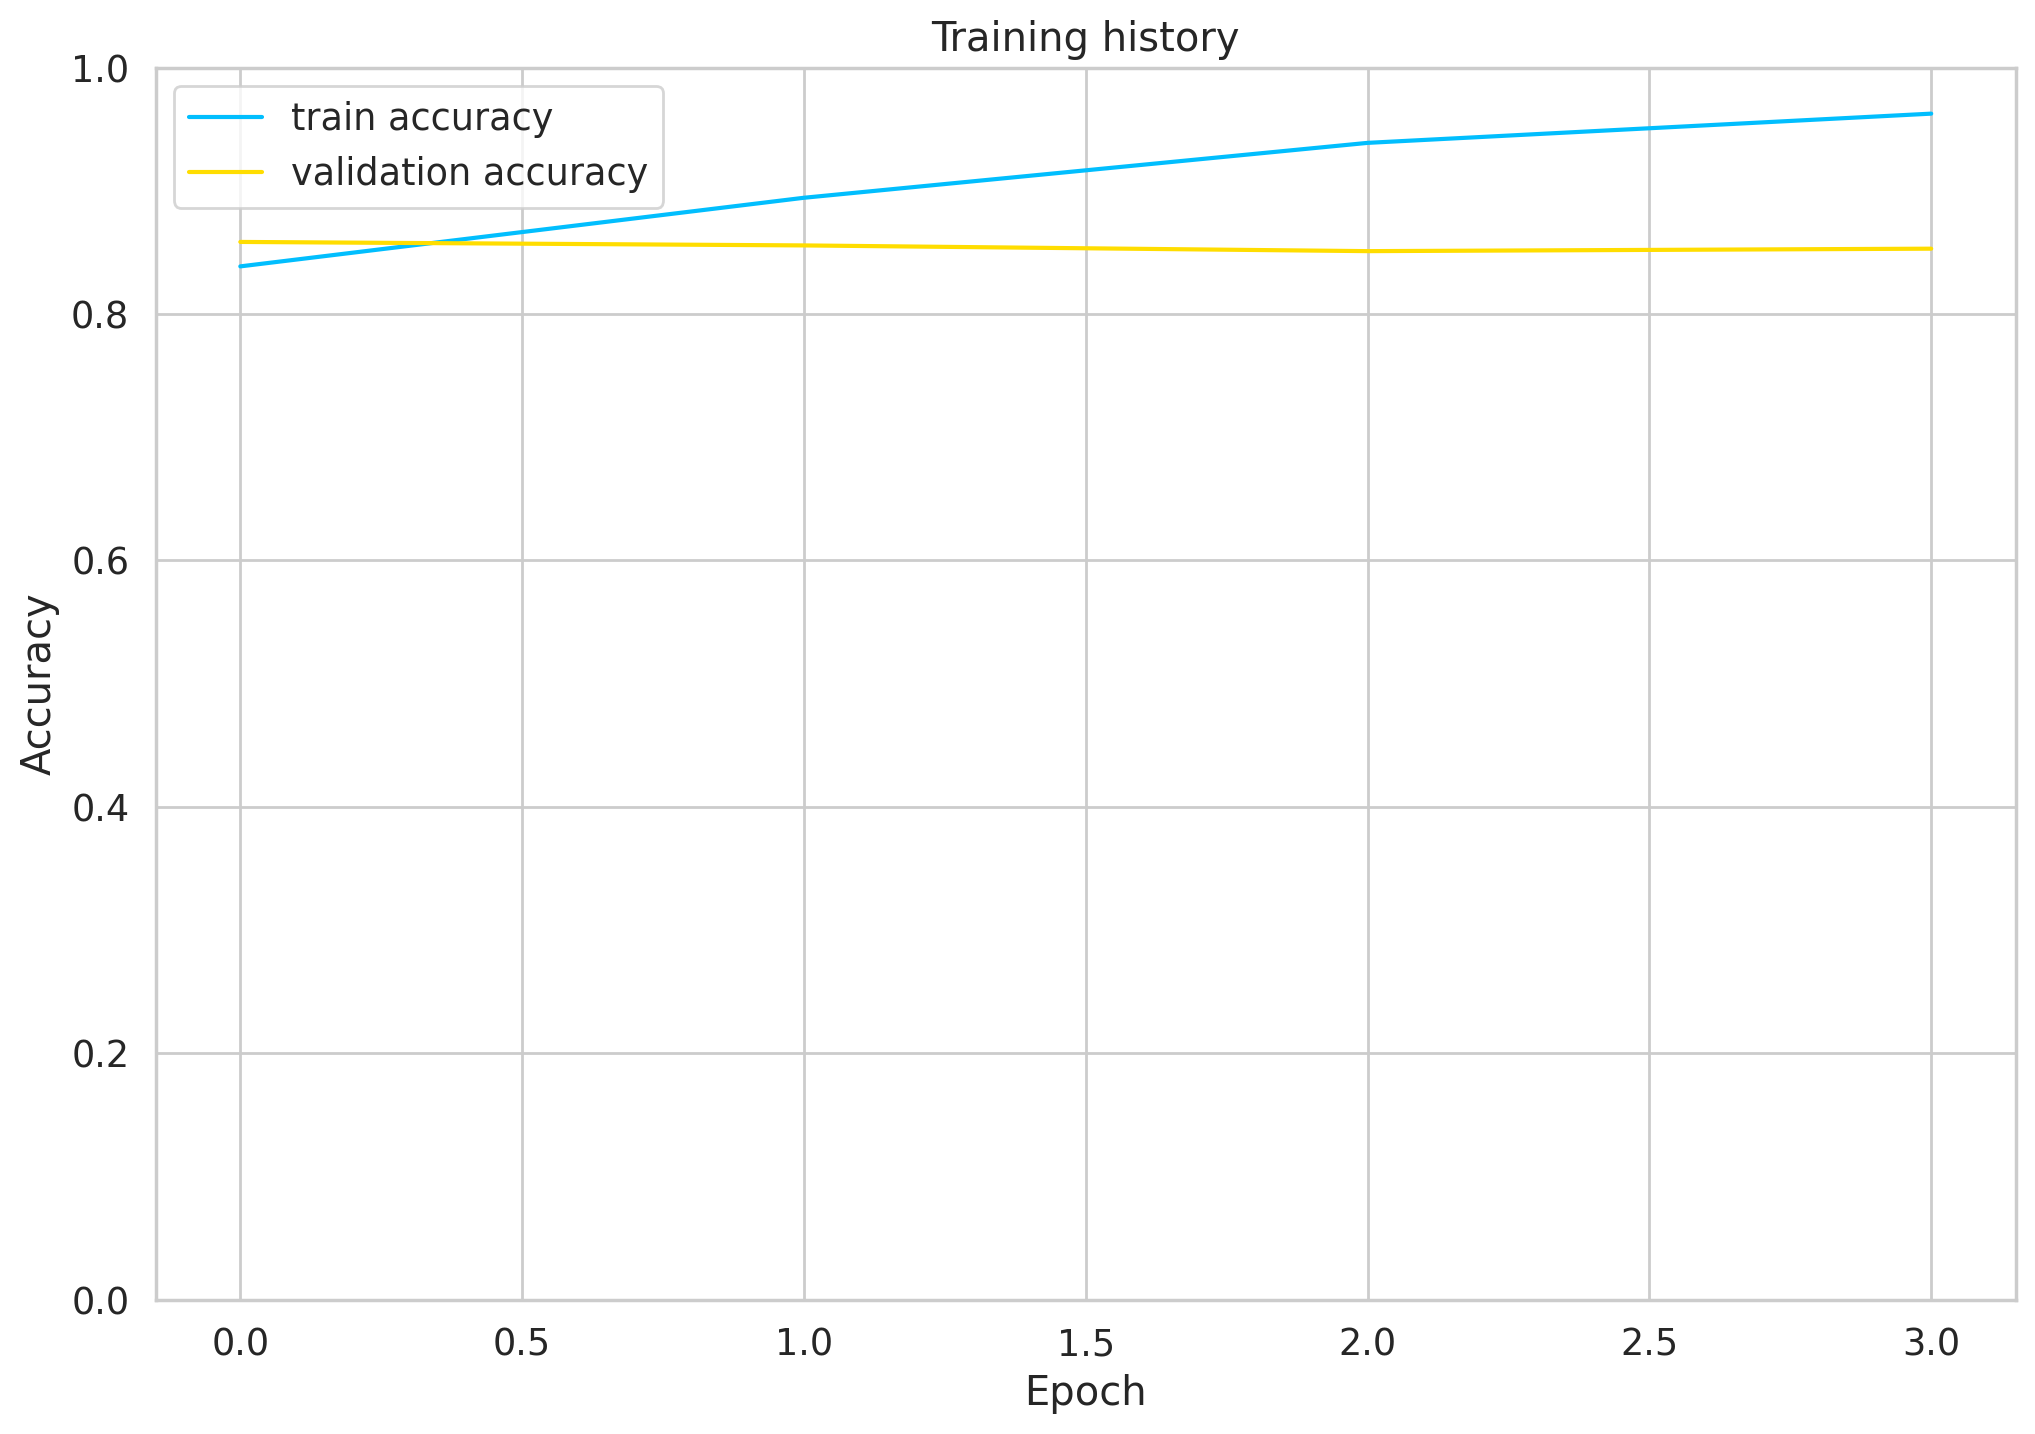

In [36]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

**Evaluation** **On** **Test**

In [37]:
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
  )

test_acc.item()

0.8529302909371782

In [47]:
def get_predictions(model, data_loader):
    model = model.eval()

    tweets_text = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_data_loader):
          tweets = batch["original_tweet"]
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          targets = batch['targets'].to(device)

          outputs = model(input_ids=input_ids, attention_mask=attention_mask)

          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          tweets_text.extend(tweets)
          predictions.extend(preds.cpu().numpy())
          prediction_probs.extend(probs.cpu().numpy())
          real_values.extend(targets.cpu().numpy())

    predictions = torch.tensor(predictions)
    prediction_probs = torch.tensor(prediction_probs)
    real_values = torch.tensor(real_values)

    return tweets_text, predictions, prediction_probs, real_values


In [48]:
y_review, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

**Classification** **Report**

In [49]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85     62066
    positive       0.85      0.85      0.85     62222

    accuracy                           0.85    124288
   macro avg       0.85      0.85      0.85    124288
weighted avg       0.85      0.85      0.85    124288



.

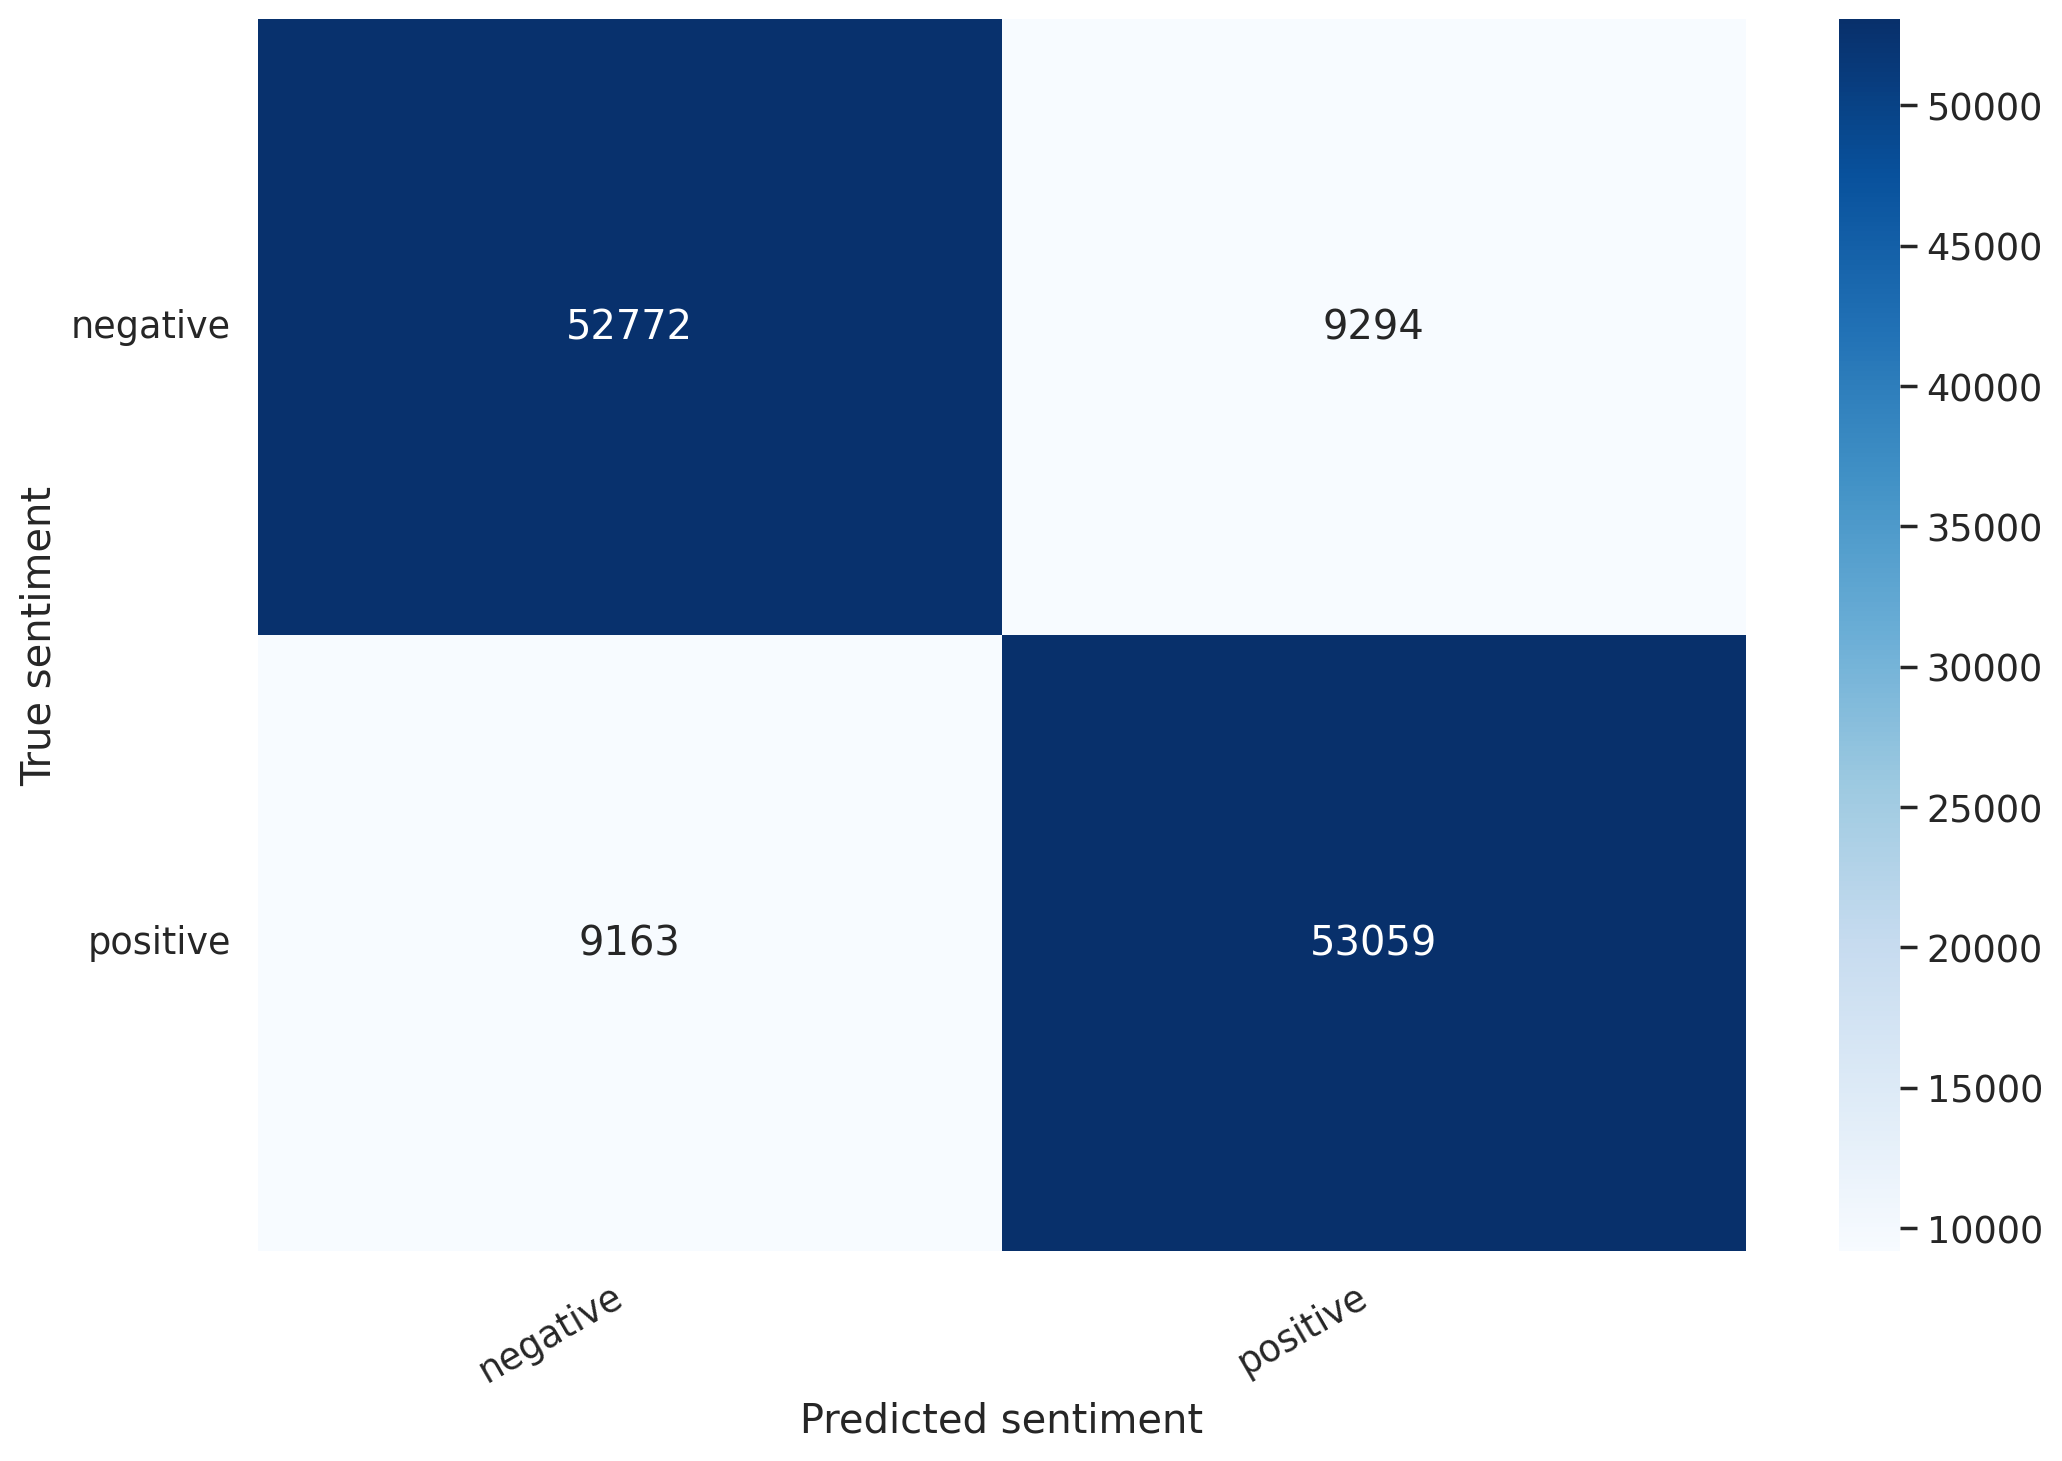

In [50]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

**Confusion** **Matrix**

.

.

.

.

**Predicting** **On** **Raw** **Text**

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"


In [51]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [52]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
